In [24]:
#import packages 
import numpy as np
import pandas as pd
import scipy.stats as sts
import os
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import special
from scipy.integrate import quad
import math

In [6]:
# Import data and do some cleaning
data = pd.read_csv('usincmoms.txt', delimiter ='\t' ,header=None)
data.columns = ['percent', 'mid']
data.head()

,percent,mid
0,0.035190,2500
1,0.041062,7500
2,0.058859,12500
3,0.056836,17500
4,0.058595,22500


### Part a:

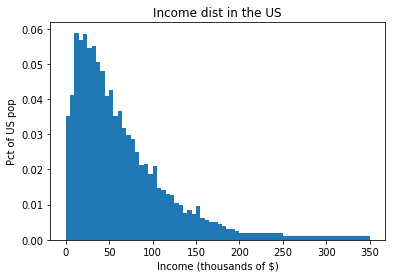

In [7]:
# Adjust for histogram
bar_h = data['percent'].copy()
bar_h[41] = data['percent'][41].copy() / 20
bar_h[40] = data['percent'][40].copy() / 10
w = np.ones(42) * 5
w[41] = 100
w[40] = 50

plt.bar(data['mid'] / 1000, bar_h, width=w, align='center')
plt.xlabel('Income (thousands of $)')
plt.ylabel('Pct of US pop')
plt.title('Income dist in the US')
plt.show()

### Part b:

In [9]:
# Define bin upper bounds
bins = np.zeros(42, dtype=np.float64)
bins[0] = 5000
# Middle range:
for i in range(1, 40):
    bins[i] = (data['mid'][i] + data['mid'][i+1])/2

bins[39] = 200000
bins[40] = 250000
bins[41] = np.inf

In [10]:
# Define functions
def model_moments(mu, sigma):
    pdf_vals = np.zeros(42, dtype=np.float64)
    dist_1 = sts.norm.cdf(np.log(bins), mu, sigma)
    bins_2 = np.roll(bins, 1)
    bins_2[0] = 1e-10
    dist_2 = sts.norm.cdf(np.log(bins_2), mu, sigma)
    pdf_vals = dist_1 - dist_2
    
    return pdf_vals

def err_vec(data_dist, mu, sigma, simple):
    moms_data = data_dist
    moms_model = model_moments(mu, sigma)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    data_dist, W = args
    err = err_vec(data_dist, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err)
    
    return crit_val

In [13]:
mu_init = 4
sig_init = 1
params_init = np.array([mu_init, sig_init])
W_hat = np.diag(data['percent'])
gmm_args = (data['percent'], W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print(results)

mu_GMM1= 10.766845399467112  sig_GMM1= 0.9078424242886773
      fun: 0.045945282536398326
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.21319099e-06, 7.31359417e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 102
      nit: 11
   status: 0
  success: True
        x: array([10.7668454 ,  0.90784242])


In [14]:
# More functions defs
def log_normal(xvals, mu, sigma):
    pdf_vals= (1/(xvals * sigma * np.sqrt(2 * np.pi)) *\
               np.exp(-(np.log(xvals) - mu)**2 /(2 * sigma**2)))
    return pdf_vals



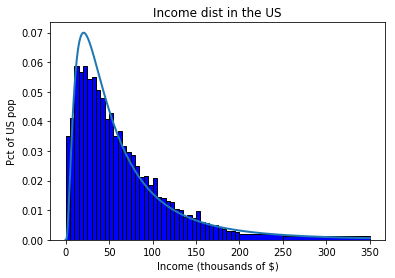

In [17]:
plt.bar(data['mid'] / 1000, bar_h, color='blue', edgecolor='k', align='center', width=w)
plt.xlabel('Income (thousands of $)')
plt.ylabel('Pct of US pop')
plt.title('Income dist in the US')

x = np.linspace(1e-3, 350000, 1000)
y = 5e3 * log_normal(x, mu_GMM1, sig_GMM1)
plt.plot(x / 1000, y, linewidth=2)
plt.show()

### Part c:

In [22]:
# Define moments functions
def model_momentsGA(xvals, alpha, beta):
    pdf_vals = 1/((beta ** alpha) * math.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)
    
    return 5000 * pdf_vals

def err_vecGA(alpha, beta, perc, simple = False):
    modelpcts = model_momentsGA(data['percent'], alpha, beta)
    if simple:
        err_vec1 = modelpcts - perc
    else:
        err_vec1 = (modelpcts - perc)/perc
    return err_vec1

def critGA(params, *args):
    alpha, beta = params
    pcts, W = args
    err = err_vecGA(alpha, beta, pcts)
    crit_val = np.dot(np.dot(err.T, W),err)
    return crit_val

In [25]:
alpha_init = 3.0
beta_init = 20000
params_init_c = np.array([alpha_init, beta_init])
gmm_args_c = (data['percent'], W_hat)

results_c = opt.minimize(critGA, params_init_c, args=(gmm_args_c),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))
alpha_gmm_c, beta_gmm_c = results_c.x

results_c

      fun: 0.9999999999766881
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([3.e+00, 2.e+04])

In [26]:
def gamma_pdf(xvals, alpha, beta):
    pdf_vals = 1/((beta ** alpha) * math.gamma(alpha)) * (xvals ** (alpha - 1)) * np.exp(-xvals/beta)
    
    return 5000 * pdf_vals



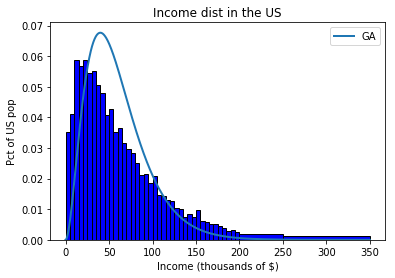

In [28]:
plt.bar(data['mid'] / 1000, bar_h, color='blue', edgecolor='k', align='center', width=w)
plt.xlabel('Income (thousands of $)')
plt.ylabel('Pct of US pop')
plt.title('Income dist in the US')

x = np.linspace(1e-3, 350000, 1000)
y2 = gamma_pdf(x, alpha_gmm_c, beta_gmm_c)
plt.plot(x / 1000, y2, linewidth=2, label="GA")
plt.legend()
plt.show()


#### Part d:

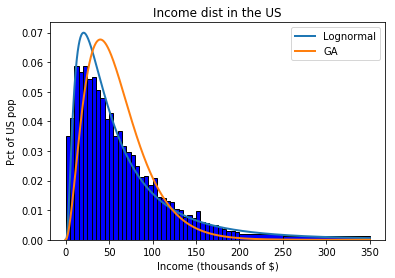

In [29]:
plt.bar(data['mid'] / 1000, bar_h, color='blue', edgecolor='k', align='center', width=w)
plt.xlabel('Income (thousands of $)')
plt.ylabel('Pct of US pop')
plt.title('Income dist in the US')

x = np.linspace(1e-3, 350000, 1000)
y = 5e3 * log_normal(x, mu_GMM1, sig_GMM1)
plt.plot(x / 1000, y, linewidth=2, label="Lognormal")
y2 = gamma_pdf(x, alpha_gmm_c, beta_gmm_c)
plt.plot(x / 1000, y2, linewidth=2, label="GA")
plt.legend()
plt.show()

From a non-rigorous visual check, it appears the lognormal approximation fits the data better

#### Part e:

In [31]:
alpha_init = 3.0
beta_init = 20000

params_init = np.array([alpha_init, beta_init])
gmm_args = (data['percent'], np.eye(42))
results_Iden = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))

alpha_GMM_Iden, beta_GMM_Iden = results_Iden.x

W_hat2 = (1/42) * (err_vec(data['percent'], alpha_GMM_Iden, beta_GMM_Iden, False).values @ \
                   err_vec(data['percent'], alpha_GMM_Iden,  beta_GMM_Iden, False).values)

gmm_args = (data['percent'], W_hat2)

results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-8, None), (1e-8, None)))

alpha_GMM_2, beta_GMM_2 = results.x
results


      fun: 2484.585112399494
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.74247996e+01, 4.54747351e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 129
      nit: 9
   status: 0
  success: True
        x: array([1.00000000e-08, 3.15754925e+01])